In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import display, HTML
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import json, sys, math, glob, os
from scipy.stats import t as ttest
import matplotlib.patches as mpatches

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.max_open_warning'] = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.insert(0, os.getcwd() + "/../../")
from analysis.utils import PM_HOME, GPU_NAME
from analysis.trace_utils import *

In [2]:
alpha = 0.05
eps = 1e-7
ncols = 10
workload_appearance_min = 5
workload_appearance_max = 10
iters = 30
root_dir = '{}/data/{}/e2e'.format(PM_HOME, GPU_NAME)
overhead_stats_files = glob.glob("{}/*/b/*overhead_stats_{}.json".format(root_dir, iters))
overhead_raw_files = glob.glob("{}/*/b/*overhead_raw_{}.csv".format(root_dir, iters))


def get_p_value(a, b):
    """
        a: tuple of 3 (mean, std, count)
        b: tuple of 3 (mean, std, count)
    """
    xa, sa, na = a
    xb, sb, nb = b
    t_stat = (xa - xb) / math.sqrt((sa * sa / na + sb * sb / nb + eps))
    # degrees of freedom
    df = na + nb - 2
    # calculate the p-value
    p = (1 - ttest.cdf(abs(t_stat), df)) * 2.0
    return p
# print(get_p_value((1.3, 0.5, 22), (1.6, 0.3, 24))) # 0.0188

def get_two_sample_ttest_hotmap(data):
    array = np.ones((len(data), len(data)))
    for idxa, a in enumerate(data):
        for idxb, b in enumerate(data):
            p = get_p_value(a[1], b[1])
            if p < alpha: # means they are not the same distribution (null hypothesis rejected)
                array[idxa, idxb] = 0
                array[idxb, idxa] = 0
    return array

In [3]:
o_stats = {
    't1': {},
    't2': {},
    't3': {},
    't4': {},
    't5': {}
}

shapes = "(((-1,),), ((-1,),))"

for file in overhead_stats_files:
    model_name = file.split('/')[-3]
    batch_size = file.split('/')[-1].split('_')[1]

    with open(file) as f:
        overhead = json.load(f)

    for t in o_stats.keys(): # Overhead types
        if t == 't1':
            o_stats[t][(model_name, batch_size)] = overhead[t]
        elif t == 't4':
            for runtime_f, s in overhead[t].items():
                if runtime_f not in o_stats[t].keys():
                    o_stats[t][runtime_f] = {}
                o_stats[t][runtime_f][(model_name, batch_size)] = s
        else:
            for op_name, s in overhead[t].items():
                bw_truncated_name = op_name.split("autograd::engine::evaluate_function: ")[-1]
                if bw_truncated_name not in o_stats[t].keys():
                    o_stats[t][bw_truncated_name] = {
                        shapes: {}
                    }
                if s[shapes][0] != 0:
                    o_stats[t][bw_truncated_name][shapes][(model_name, batch_size)] = s[shapes]

for t in ['t2', 't3', 't5']:
    # Remove trivial stats
    del_names = []
    for k, v in o_stats[t].items():
        if len(v[shapes].keys()) <= workload_appearance_min: # Appear in less than xx model-batch workloads
            del_names.append(k)
    for k in del_names:
        del o_stats[t][k]

df = gather_overhead_raw(overhead_raw_files)

In [4]:
order = ["DLRM_default", "DLRM_MLPerf", "DLRM_DDP"]
t1 = df[df['type'] == 't1']
gb = t1.groupby(['model_name', 'batch_size'])
t1s = [gb.get_group(x) for x in gb.groups]
t1s = sorted(
    t1s, 
    key=lambda x: (order.index(x.iloc[0]['model_name']), int(x.iloc[0]['batch_size']))
)

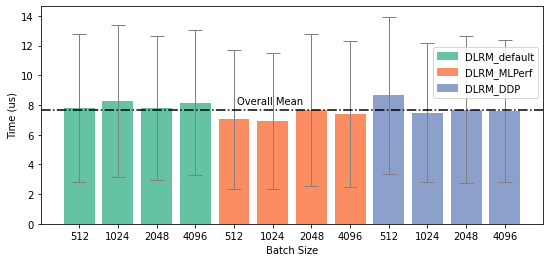

In [5]:
s = [("-".join([x.iloc[0]['model_name'], x.iloc[0]['batch_size']]), x['time'].mean(), x['time'].std(), len(x)) for x in t1s]
labels = [x[0] for x in s]
avg = t1["time"].mean()
plt.figure(figsize=(9, 4))
ax = plt.gca()
ax.bar(
    [x[0] for x in s], [x[1] for x in s],
    color=[plt.get_cmap("Set2")(order.index(x.split('-')[0])) for x in labels],
    yerr=[x[2] for x in s],
    align='center',
    error_kw={
        "elinewidth": 1,
        "capsize": 7,
        "ecolor": 'grey',
    }
)
ax.axhline(avg, color='black', linestyle="-.")
ax.text(0.39, 0.55, "Overall Mean", transform=ax.transAxes)
_ = ax.set_xticks(np.arange(len(s)))
_ = ax.set_xticklabels([l.split('-')[1] for l in labels], fontsize=10)
_ = ax.set_xlabel("Batch Size")
_ = ax.set_ylabel("Time (us)")
_ = ax.legend(
    handles=[
        mpatches.Patch(color=plt.get_cmap("Set2")(idx), label=order[idx]) \
            for idx in range(len(order))
        ],
    loc=(0.78, 0.58),
)
plt.savefig('{}/data/overheads_t1.pdf'.format(PM_HOME), bbox_inches='tight')
plt.savefig('{}/data/overheads_t1.png'.format(PM_HOME), bbox_inches='tight')

### T2, T3, T5

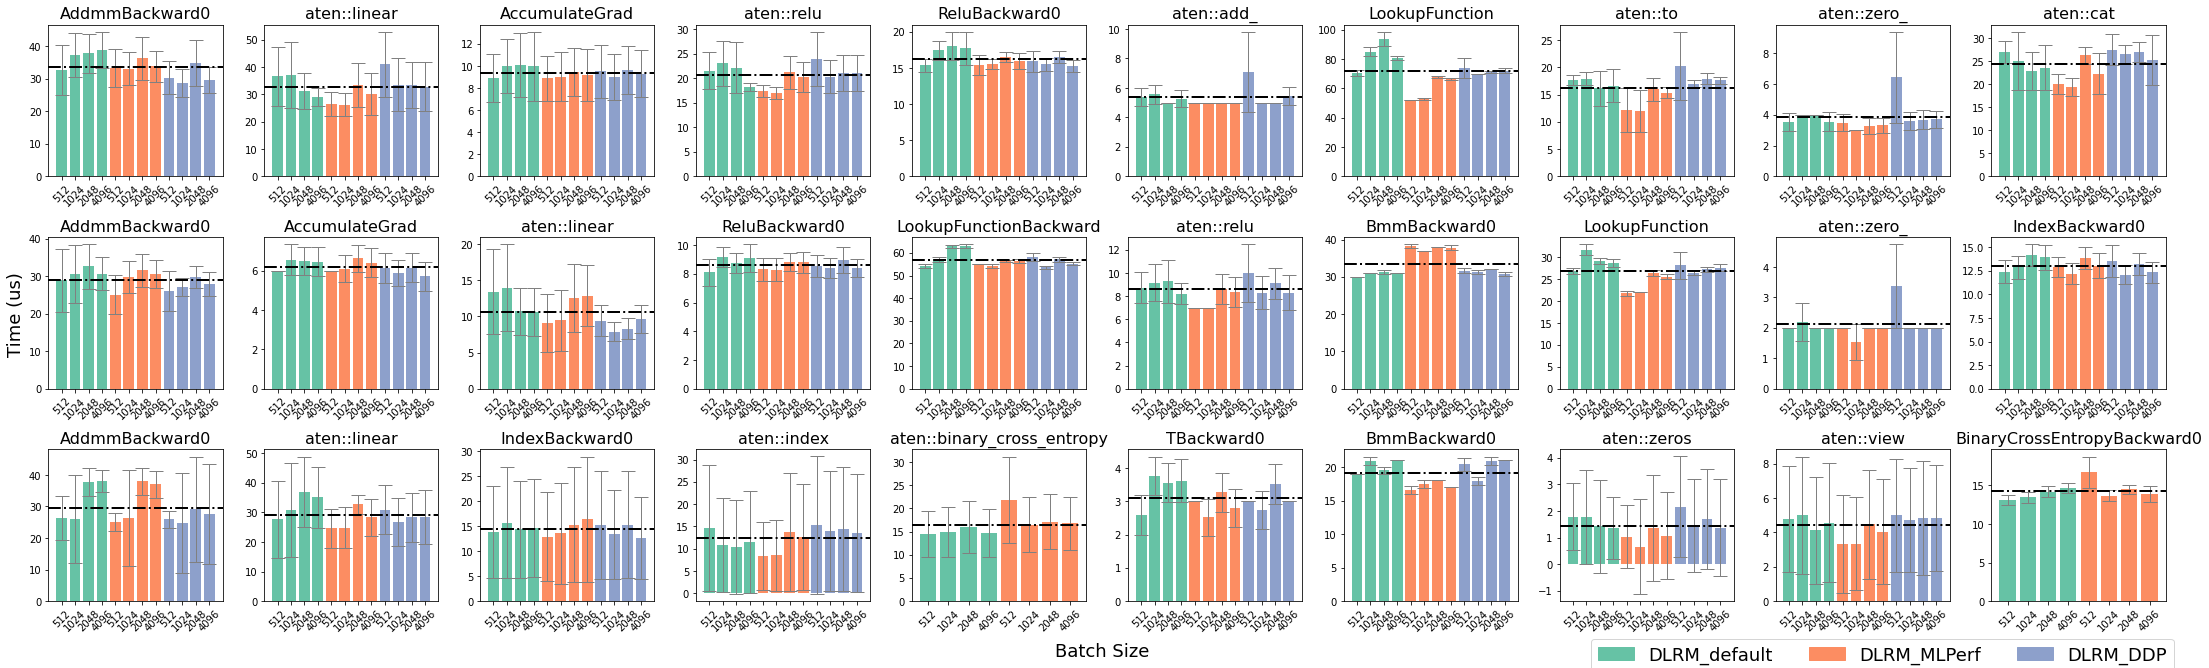

In [6]:
"""
o_stats = {
    op1: {
        shapes: {
            (model_name, batch_size): [mean, std, count]
        }
    },
    op2: {
        shapes: {
            (model_name, batch_size): [mean, std, count]
        }
    },
    ...
}
"""

def f(x):
    k = x[shapes].values()
    return -sum([kk[0] * kk[2] for kk in k])

fig, axs = plt.subplots(
    nrows=3,
    ncols=workload_appearance_max,
    figsize=(workload_appearance_max * 3, 9)
)

for i, t in enumerate(['t2', 't3', 't5']):
    # Sort ops by sum time
    stats = sorted(o_stats[t].items(), key=lambda v: f(v[1]))

    for j, (op_name, s) in enumerate(stats[:workload_appearance_max]):
        t = sorted(
            s[shapes].items(),
            key=lambda x: (order.index(x[0][0]), int(x[0][1]))
        )
        t = [("-".join([x[0][0], x[0][1]]), x[1][0], x[1][1], x[1][2]) for x in t]
        avg = sum([x[1] * x[3] for x in t]) / sum([x[3] for x in t])
        ax = axs[i][j]
        ax.bar(
            [x[0] for x in t], [x[1] for x in t],
            color=[plt.get_cmap("Set2")(order.index(x.split('-')[0])) for x in labels],
            yerr=[x[2] for x in t],
            align='center',
            error_kw={
                "elinewidth": 1,
                "capsize": 7,
                "ecolor": 'grey',
            }
        )
        ax.axhline(avg, color='black', linestyle="-.", linewidth=2)
        ax.set_title(op_name if "autograd" not in op_name else op_name.split("::")[-1], fontsize=16)
        _ = ax.set_xticks(np.arange(len(t)))
        _ = ax.set_xticklabels([l[0].split('-')[1] for l in t], fontsize=10, rotation=45)
_ = fig.legend(
    handles=[
        mpatches.Patch(color=plt.get_cmap("Set2")(idx), label=order[idx]) \
            for idx in range(len(order))
        ],
    loc=(0.72, -0.005),
    ncol=3,
    fontsize=18,
)
fig.text(-0.005, 0.45, "Time (us)", fontsize=18, rotation=90)
fig.text(0.48, -0.02, "Batch Size", fontsize=18)
plt.tight_layout()
plt.savefig('{}/data/overheads_t235.pdf'.format(PM_HOME), bbox_inches='tight')
plt.savefig('{}/data/overheads_t235.png'.format(PM_HOME), bbox_inches='tight')